# Stateless and Stateful LSTM models for multivariate time series data

<div class="alert alert-block alert-success">

**Featuring:**
1. Generators for batch preprocessing
2. Multistep Prediction: the model does not get any "true" data after the very first batch, the data is sequentially replaced with model's predictions!  
3. Hose validation

</div>

**Table of contents**
- [Stateful Model](#stateful)
- [Stateless Model](#stateless)


<div class="alert alert-block alert-info">
<b>Recommended Links for deeper understanding </b>
    
- Template for TimeseriesGenerator
https://keras.io/preprocessing/sequence/  

- Stateful LSTM example
https://keras.io/examples/lstm_stateful/
</div>

<div class="alert alert-block alert-danger">

**Known issues:** 
- both models have problems on unseen data in case of falling Vin below 5V and enable signal (true: no output, prediction: rising Vout)
</div>

<div class="alert alert-block alert-warning">

**Improvement options** via GRID SEARCH
- Number of Cells
- Dropout
- LSTM Stacking
- CNN/LSTM Combi

**Future:** 
- Classification instead of regression
- YELLOWBRICK for Grid Search visualization
</div>

In [177]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web
# import pandas_profiling # https://habr.com/ru/post/457302/
import seaborn as sns
#%matplotlib inline # restart the kernel if you switch between the two commands below!
# for interactive plotting use notebook word
%matplotlib notebook 
import matplotlib.pyplot as plt
import random, time, math

np.random.seed(7)

## Importing and Preprocessing the data

In [138]:
df=pd.read_csv('simple_data5.csv')# test_data5.csv or simple_data5.csv

In [139]:
df.head()

,time,Vin,Enable,Vout
0,05:55:43 PM,-0.001,0.0,-0.001
1,05:55:44 PM,0.000,0.0,0.000
2,05:55:45 PM,-0.001,0.0,-0.001
3,05:55:46 PM,0.001,0.0,0.001
4,05:55:47 PM,-0.001,0.0,-0.001


In [140]:
df.shape

(2128, 4)

### Clean the data

<div class="alert alert-block alert-warning">
Get rid of NaN if available, because keras will tolerate it >> but will kill the validation for example if you validate on last 20% that contain NaN!
    
    np.where(np.isnan(measured_signal)) # used for debugging originally
</div>

In [141]:
df.dropna(inplace=True)

In [142]:
df.shape

(2128, 4)

### Convert time column to datetime object 
the time column was not imported as datetime object >> convert it

In [143]:
df.dtypes

time       object
Vin       float64
Enable    float64
Vout      float64
dtype: object

In [144]:
df['time']=pd.to_datetime(df['time'])

In [145]:
df.dtypes

time      datetime64[ns]
Vin              float64
Enable           float64
Vout             float64
dtype: object

In [146]:
df.time.min(),df.time.max()

(Timestamp('2019-07-07 17:55:43'), Timestamp('2019-07-07 18:31:10'))

### Check the ranges and Visualize the data

In [147]:
df.describe()

,Vin,Enable,Vout
count,2128.000000,2128.000000,2128.000000
mean,5.060235,2.137154,1.682446
std,6.217373,2.463160,3.270454
min,-0.100000,0.000000,-0.001000
25%,0.000000,0.000000,-0.001000
50%,0.400000,0.000000,0.000000
75%,11.480000,5.000000,0.001000
max,20.400000,5.010000,8.550000


<IPython.core.display.Javascript object>


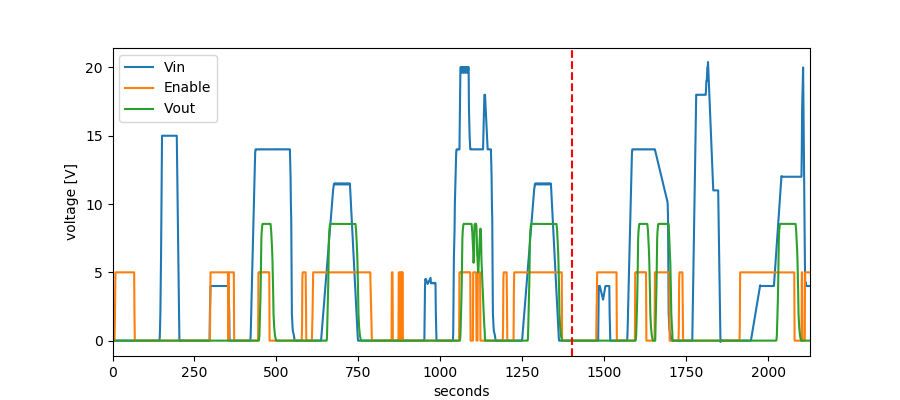

In [178]:
# show all

df[['Vin','Enable','Vout']].plot(figsize=(9,4));
#df[['Vin','Enable','Vout']].iloc[:,:].plot(figsize=(14,5));
# problem part - this will be for validation, unseen data
#df[['Vin','Enable','Vout']].iloc[1400:,:].plot(figsize=(14,5));

plt.xlabel('seconds'), plt.ylabel('voltage [V]');

#visualize the chosen split point >> it should be where all signals = zero!
plt.axvline(1400, color='red',linestyle='--'); # show the pslit point between train and validation part


<div class="alert alert-block alert-success">
SUCCESS: you can zoom into region(s) of interest. The dataframe is ready for converting to format the LSTM expects.
</div>

### Convert the chosen split point to percent

In [149]:
1400/df.shape[0]

0.6578947368421053

*ratio_split* parameter below is 0.65

### Resample the data

### Convert DataFrame to NumPy array for LSTM processing

In [150]:
mydata=df[['Vin','Enable','Vout']].values

In [151]:
mydata.shape
#plt.plot(mydata);

(2128, 3)

### Scaling 
use Ctrl + Slash / to (un)comment the step below

<div class="alert alert-block alert-danger">
Rescaling the signal before fitting: moderate success with StandardScaler, bullshit with MinMaxScaler
</div>

In [152]:
# scaler = StandardScaler() # MinMaxScaler
# scaler.fit(mydata)
# mydata=scaler.transform(mydata)
# plt.plot(mydata)

<a id='stateful'></a>
## Train and Validate the Stateful Model

### Define the hyperparameters like batch size, number of epochs

**1 sample = 1 window with signals we want to use for prediction and the target value(s)**, so 1 sample contains *lahead* time steps of the signals, so for 3 signals and 10 timesteps we get a sample with 3x10 values and one target value (in this application we predict only one signal)  
  
  
**1 batch contains N=batch_size samples** The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters = weights.

In [153]:
# number of input variables = features
n_features=mydata.shape[1]

ratio_split=0.65 # 0.65 classics: split train and validation data 80% to 20%, so 0.8

# get the index for splitting
my_split_index = int(mydata.shape[0] * ratio_split)

# The input sequence length (in time steps) that the LSTM is trained on for each output point
lahead = 5 # 5 [time steps] "length of steps to predict the ahead value", we could call it numlags
my_stride=1# 1 lahead
# training parameters passed to "model.fit(...)"
my_batch_size = 1 # 5 number of samples in each batch
epochs_to_train = 30 # 15 benchmark

# the next value defines the column to be predicted, this code supports one feature prediction only
my_target_index=2 # because the target column Vout has index 2

# slice the column for prediction
mytargets=mydata[:,my_target_index] # if you want just the next sample to be the target for prediction

### Create the training batches

In [111]:
training_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=my_stride,
                               end_index=my_split_index,
                               shuffle=False)

In [112]:
print('1 Epoch contains ',len(training_data_generator),' batches with each ', my_batch_size,'samples')
print('Each sample windows contains ',lahead,' time steps of the chosen signals')

1 Epoch contains  1379  batches with each  1 samples
Each sample windows contains  5  time steps of the chosen signals


### Create validation batches

In [113]:
validation_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=my_stride,
                               start_index=my_split_index,
                               shuffle=False)

In [115]:
def create_model(stateful):
    model = Sequential() # orig LTSM(20)
    model.add(LSTM(40, #40
              #input_shape=(lahead, n_features),              
              batch_input_shape=(1,lahead, n_features),              
              return_sequences=True,
              stateful=stateful))
    #model.add(Dropout(0.1)) # 0.1
    #model.add(LSTM(40,return_sequences=True,stateful=stateful)) # 40
    #model.add(Dropout(0.1)) # 0.1
    model.add(LSTM(40,stateful=stateful)) # 40
    model.add(Dropout(0.1)) # 0.1
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [116]:
print('Creating Statefull Model...')
model_stateful = create_model(stateful=True);

Creating Statefull Model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [117]:
for i in range(epochs_to_train):
    print('Epoch', i + 1, '/', epochs_to_train)
    model_stateful.fit_generator(training_data_generator, 
                              epochs=1,
                              validation_data=validation_data_generator)
    model_stateful.reset_states()# needed for stateful training

Epoch 1 / 30
Epoch 1/1
1379/1379 [==============================] - 11s 8ms/step - loss: 0.9777 - val_loss: 0.1782
Epoch 2 / 30
Epoch 1/1
1379/1379 [==============================] - 9s 7ms/step - loss: 0.1581 - val_loss: 0.0743
Epoch 3 / 30
Epoch 1/1
1379/1379 [==============================] - 9s 7ms/step - loss: 0.1358 - val_loss: 0.0487
Epoch 4 / 30
Epoch 1/1
1379/1379 [==============================] - 9s 7ms/step - loss: 0.1484 - val_loss: 0.0973
Epoch 5 / 30
Epoch 1/1
1379/1379 [==============================] - 10s 7ms/step - loss: 0.1146 - val_loss: 0.0511
Epoch 6 / 30
Epoch 1/1
1379/1379 [==============================] - 11s 8ms/step - loss: 0.1077 - val_loss: 0.0231
Epoch 7 / 30
Epoch 1/1
1379/1379 [==============================] - 10s 7ms/step - loss: 0.0932 - val_loss: 0.0300
Epoch 8 / 30
Epoch 1/1
1379/1379 [==============================] - 10s 7ms/step - loss: 0.0818 - val_loss: 0.1278
Epoch 9 / 30
Epoch 1/1
1379/1379 [==============================] - 11s 8ms/step - 

### Visualize the measured and predicted waveforms

You can load another test dataset if wanted or comment the cell below out (it uses the same mydata/mytargets names) so that the complete original dataset will be used

<IPython.core.display.Javascript object>


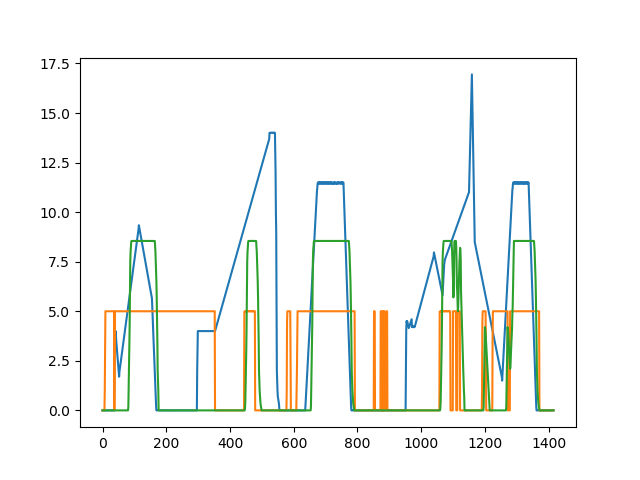

In [129]:
# df=pd.read_csv('test_data5.csv')
# df.dropna(inplace=True)
# mydata=df[['Vin','Enable','Vout']].values
# # slice the column for prediction
# mytargets=mydata[:,my_target_index] # if you want just the next sample to be the target for prediction
# plt.figure()
# plt.plot(mydata);

**Recursive predicting multivariate multi-step problem with LSTM**

In [154]:
test_start_index=0 # simply choosen the index on the plot to start predicting
my_batch_size=1
my_stride=1
test_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=my_stride,
                               start_index=test_start_index,
                               end_index=df.shape[0]-1,
                               shuffle=False)

In [155]:
model_stateful.reset_states()
predicted_signal=[]
measured_signal=[]

for i in range(len(test_data_generator)):
    
    x,y=test_data_generator[i] # get the next batch with one sample

    if i:
        # roll the values -1
        target_column=np.roll(target_column,-1)
        #replace the last value with previously predicted value
        target_column[0,-1]=target_value
        #replace the target column with previously predicted values
        x[...,my_target_index]=target_column
                
    else:
        #this code is run only once at start
        #extract the first column with target data
        
        target_column=x[...,my_target_index]
    
    target_value = model_stateful.predict(x, verbose=0)
    predicted_signal.append(float(target_value))
    measured_signal.append(float(y))

<IPython.core.display.Javascript object>


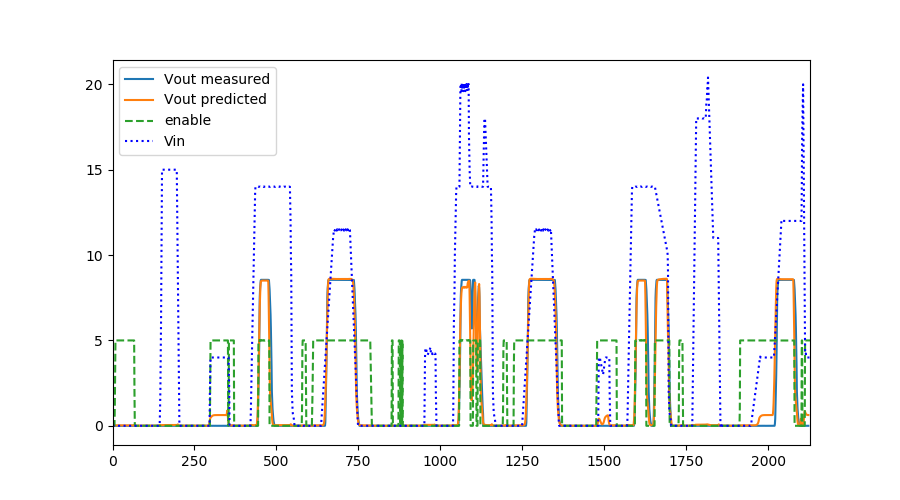

In [156]:
plt.figure(figsize=(9,5))
plt.plot(measured_signal)
plt.plot(predicted_signal)
df['Enable'].plot(linestyle='--')
df['Vin'].plot(linestyle=':',c='b')
plt.legend(['Vout measured','Vout predicted','enable','Vin']);

<IPython.core.display.Javascript object>


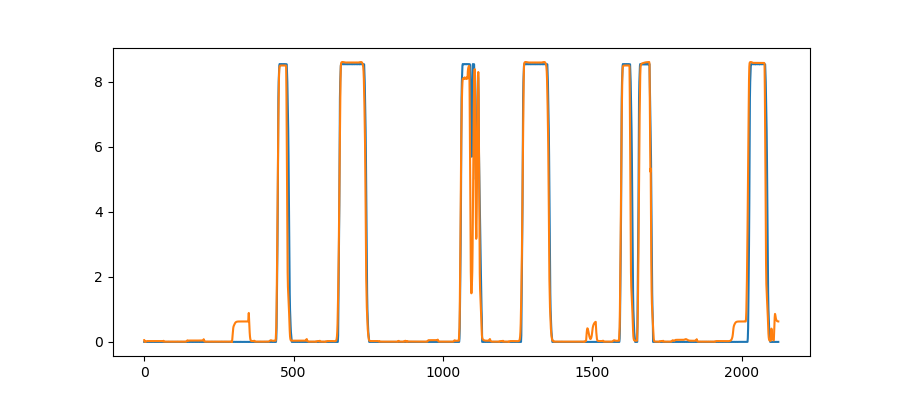

In [157]:
plt.figure(figsize=(9,4))
plt.plot(measured_signal)
plt.plot(predicted_signal);

### Classical Error Metrics

In [134]:
mae=mean_absolute_error(measured_signal,predicted_signal)
mse=mean_squared_error(measured_signal,predicted_signal)
rmse=math.sqrt(mse)
mae, mse, rmse

(0.30286073617441783, 0.7126762925419831, 0.8442015710373815)

### Error Visualization on multistep forecast: Hose Validation Function

In [135]:
def hose_validation_function(reference_array, 
                    follower_array, 
                    hose_width=7,
                    signal_tolerance=0.1):
    '''
    this function takes two waveforms and checks whether the "follower" waveform 
    really follows the reference waveform
    hose_width: number of samples to check (for each reference point take hose_width samples)
    '''
    # create a 2D array with tolerance values around the reference values
    
    reference_array=np.array(reference_array)
    follower_array=np.array(follower_array)
    
    limit_array=np.array((reference_array - signal_tolerance,
                         reference_array + signal_tolerance))
    limit_array=limit_array.transpose() # get the column form (x,y)>>(y,x)
    
    # roll the array forward because the keras generator sees the target after the sequence
    limit_array=np.roll(limit_array,hose_width//2+1,axis=0)

    
    hose_data_generator = TimeseriesGenerator(follower_array, limit_array,
                               length=hose_width,
                               batch_size=1)

    # output of generator is a tuple (x,y) features,target
    result=[] # True if hose violation >> "positive" >> value outside the hose
    for vals,limits in hose_data_generator:

        clipped_vals = lambda vals, limits : np.clip(vals, limits[0,0],limits[0,1])
        t=clipped_vals(vals,limits)

        result.append(False) if len(np.setdiff1d(t,limits)) else result.append(True)
        shift=hose_width//2+hose_width%2-1
    
    #reference_array=reference_array[]
    
    return result,shift

<IPython.core.display.Javascript object>


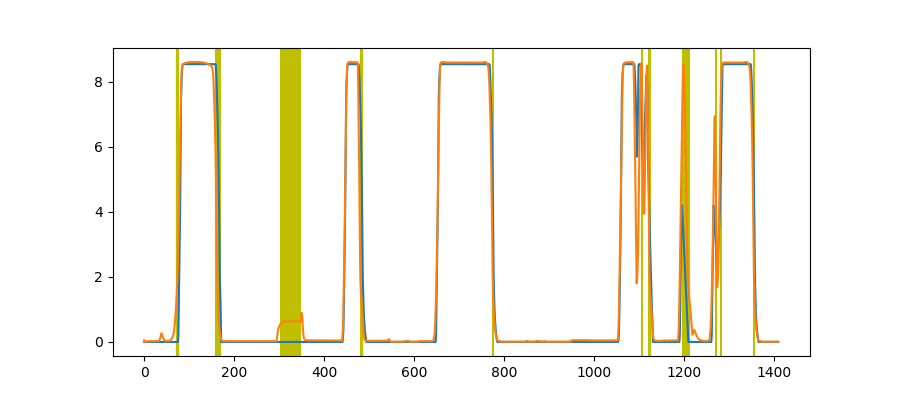

80


In [136]:
plt.figure(figsize=(9,4))

result,shift=hose_validation_function(measured_signal,predicted_signal,hose_width=10,signal_tolerance=0.5)

errors=0
for counter,value_not_in_hose in enumerate(result):

    if value_not_in_hose:
        errors+=1
        plt.axvline(shift+counter,c='y')

plt.plot(measured_signal)
plt.plot(predicted_signal)
print(errors)

# ToDo Feature1: replace boolean with 1,0 >> sum gives the errors, 
# Feature2 pad the shift with zeros (no enumerate needed any more)

<a id='stateless'></a>
## Train and Validate the Stateless Model

In [158]:
# number of input variables = features
n_features=mydata.shape[1]

ratio_split=0.65 # split train and validation data 80% to 20%

# get the index for splitting
my_split_index = int(mydata.shape[0] * ratio_split)

# The input sequence length (in time steps) that the LSTM is trained on for each output point
lahead = 4 # 10  [time steps] "length of steps to predict the ahead value", we could call it numlags

# training parameters passed to "model.fit(...)"
my_batch_size = 10 # 1 number of samples in each batch
epochs_to_train = 50 # 40     100 or 1000 possible


# the next value defines the column to be predicted, this code supports one feature prediction only
my_target_index=2 # because the target column Vout has index 2

# slice the column for prediction
mytargets=mydata[:,my_target_index] # if you want just the next sample to be the target for prediction

### Create the training batches

In [159]:
training_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=1,
                               end_index=my_split_index,
                               shuffle=False)

**Show one batch and its content**

In [160]:
print('1 Epoch contains ',len(training_data_generator),' batches with each ', my_batch_size,'samples')
print('Each sample windows contains ',lahead,' time steps of the chosen signals')

1 Epoch contains  138  batches with each  10 samples
Each sample windows contains  4  time steps of the chosen signals


In [161]:
x,y=training_data_generator[0]
print('the first training batch has the dimensions:',x.shape)

the first training batch has the dimensions: (10, 4, 3)


The last sample in the first batch:

In [162]:
x[-1,...]

array([[ 1.e-03,  5.e+00,  1.e-03],
       [-1.e-03,  5.e+00, -1.e-03],
       [ 0.e+00,  5.e+00,  0.e+00],
       [ 1.e-03,  5.e+00,  1.e-03]])

In [163]:
y.shape # clear, the dimension of y corresponds the batch_size

(10,)

### Create validation batches

In [164]:
validation_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=1,
                               start_index=my_split_index,
                               shuffle=False)

In [165]:
len(validation_data_generator)

75

### Compile the Stateless LSTM model

Best 40-20-dropout 0.2

In [166]:
def create_model(stateful):
    model = Sequential() # orig LTSM(20)
    model.add(LSTM(50,
              input_shape=(lahead, n_features),              
              #batch_input_shape=(1,lahead, n_features),              
              return_sequences=True,
              stateful=stateful))
    model.add(LSTM(50,stateful=stateful)) # 20
    model.add(Dropout(0.1)) # 0.2
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [167]:
print('Creating Stateless Model...')
model_stateless = create_model(stateful=False);

Creating Stateless Model...


In [168]:
model_stateless.fit_generator(training_data_generator, 
                              epochs=epochs_to_train,
                              validation_data=validation_data_generator)

Epoch 1/50
138/138 [==============================] - 3s 25ms/step - loss: 4.6380 - val_loss: 0.2122
Epoch 2/50
138/138 [==============================] - 1s 9ms/step - loss: 0.2168 - val_loss: 0.0996
Epoch 3/50
138/138 [==============================] - 1s 8ms/step - loss: 0.2121 - val_loss: 0.1120
Epoch 4/50
138/138 [==============================] - 1s 8ms/step - loss: 0.1420 - val_loss: 0.1214
Epoch 5/50
138/138 [==============================] - 1s 8ms/step - loss: 0.1359 - val_loss: 0.0928
Epoch 6/50
138/138 [==============================] - 1s 8ms/step - loss: 0.1010 - val_loss: 0.0935
Epoch 7/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1686 - val_loss: 0.1462
Epoch 8/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1347 - val_loss: 0.3272
Epoch 9/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1950 - val_loss: 0.1468
Epoch 10/50
138/138 [==============================] - 1s 8ms/step - loss: 0.1322 - val_loss: 0.096

In [ ]:
x,y=validation_data_generator[2]

In [ ]:
yhat = model_stateless.predict(x, verbose=0)

In [ ]:
yhat

In [ ]:
mydata.shape

### Recursive predicting multivariate multi-step problem with lstm

In [169]:
test_index=0 # simply choosen the index on the plot to start predicting
my_batch_size=1
test_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=lahead, 
                               sampling_rate=1,
                               batch_size=my_batch_size, 
                               stride=1,
                               start_index=test_index,
                               end_index=df.shape[0]-1,
                               shuffle=False)

In [170]:
predicted_signal=[]
measured_signal=[]

for i in range(len(test_data_generator)):
    
    x,y=test_data_generator[i] # get the next batch with one sample

    if i:
        # roll the values -1
        target_column=np.roll(target_column,-1)
        #replace the last value with previously predicted value
        target_column[0,-1]=target_value
        #replace the target column with previously predicted values
        x[...,my_target_index]=target_column
                
    else:
        #this code is run only once at start
        #extract the first column with target data
        
        target_column=x[...,my_target_index]
    
    target_value = model_stateless.predict(x, verbose=0)
    predicted_signal.append(float(target_value))
    measured_signal.append(float(y))
    
    
    

<IPython.core.display.Javascript object>


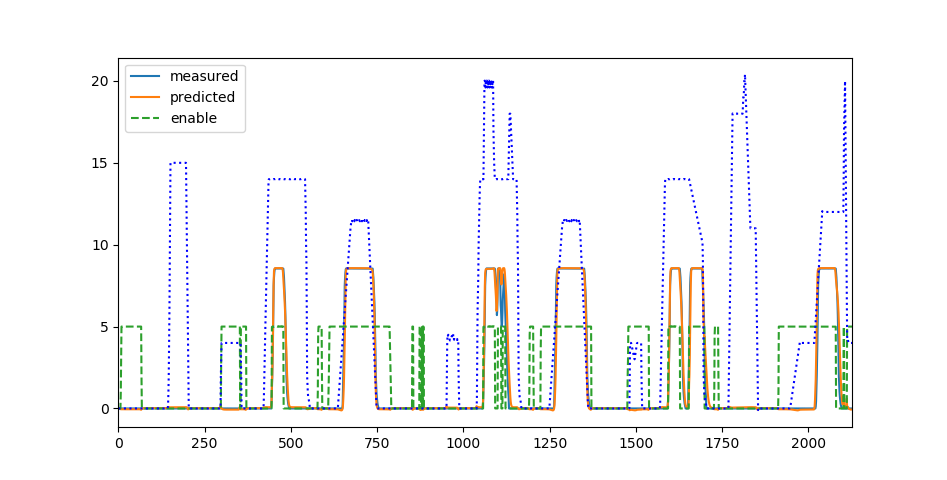

In [172]:
plt.figure()
plt.plot(measured_signal)
plt.plot(predicted_signal)
df['Enable'].plot(linestyle='--')
df['Vin'].plot(linestyle=':',c='b')
plt.legend(['measured','predicted','enable']);

<IPython.core.display.Javascript object>


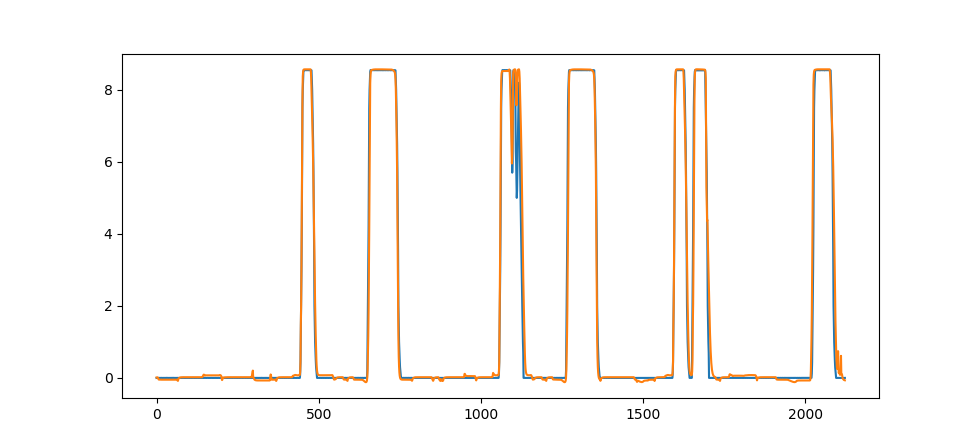

In [173]:
plt.figure()#figsize=(17,8)
plt.plot(measured_signal)

plt.plot(predicted_signal);

<IPython.core.display.Javascript object>


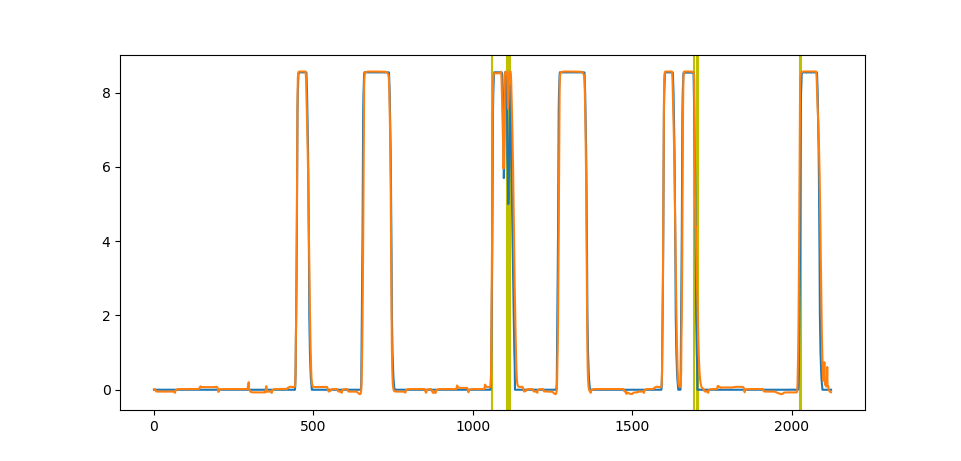

14


In [175]:
plt.figure()

result,shift=hose_validation_function(measured_signal,predicted_signal,hose_width=10,signal_tolerance=0.5)

errors=0
for counter,value_not_in_hose in enumerate(result):

    if value_not_in_hose:
        errors+=1
        plt.axvline(shift+counter,c='y')

plt.plot(measured_signal)
plt.plot(predicted_signal)
print(errors)

# ToDo Feature1: replace boolean with 1,0 >> sum gives the errors, 
# Feature2 pad the shift with zeros (no enumerate needed any more)

### Error Metrics on multistep forecast

In [ ]:
mae=mean_absolute_error(measured_signal,predicted_signal)
mse=mean_squared_error(measured_signal,predicted_signal)
rmse=math.sqrt(mse)
mae, mse, rmse

### Just show the maximum absolute error ["normal" metrics are not suitable for multistep predicting]

In [ ]:
max(abs(np.array(predicted_signal)-np.array(measured_signal)))

### Grid Search the "right" hyperparameters

In [ ]:
# number of input variables = features
n_features=mydata.shape[1]

#-------------------------------------------------------------------------------------------------------
ratio_split=0.65 # split train and validation data 80% to 20%
my_split_index = int(mydata.shape[0] * ratio_split) # get the index for splitting 
#-------------------------------------------------------------------------------------------------------

# The input sequence length (in time steps) that the LSTM is trained on for each output point
lahead = [5,50] # [time steps] "length of steps to predict the ahead value", we could call it numlags
my_batch_size = [5,100] # number of samples in each batch
epochs_to_train = [20,50] #  100 or 1000 possible

#--------------------------------------------------------------------------------------------------------
# the next value defines the column to be predicted, this code supports one feature prediction only
my_target_index=2 # because the target column Vout has index 2
# slice the column for prediction
mytargets=mydata[:,my_target_index] # if you want just the next sample to be the target for prediction
#--------------------------------------------------------------------------------------------------------



In [ ]:
def create_model(stateful):
    model = Sequential()
    model.add(LSTM(40,
              input_shape=(grid_lahead, n_features),
              stateful=stateful))
    #model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

In [ ]:
for grid_batch_size in my_batch_size:
    for grid_lahead in lahead:
        for grid_epochs_to_train in epochs_to_train:
  
            training_data_generator = TimeseriesGenerator(mydata, mytargets,
                                           length=grid_lahead, sampling_rate=1,
                                           batch_size=grid_batch_size, 
                                           end_index=my_split_index)

            validation_data_generator = TimeseriesGenerator(mydata, mytargets,
                                           length=grid_lahead, sampling_rate=1,
                                           batch_size=grid_batch_size, 
                                           start_index=my_split_index)

            model_stateless = create_model(stateful=False);
            
            # TIME CONSUMING FITTING
            model_stateless.fit_generator(training_data_generator, 
                              epochs=grid_epochs_to_train,
                              validation_data=validation_data_generator,
                              verbose=0)
            print('Batch size: {0}| lahead steps: {1}| epochs: {2}'.\
                  format(grid_batch_size,grid_lahead,grid_epochs_to_train))
            
            # PREDICTION STAGE ---------------------------------------------------------
            test_index=0 # simply choosen the index on the plot to start predicting
            test_batch_size=1
            test_data_generator = TimeseriesGenerator(mydata, mytargets,
                               length=grid_lahead, 
                               batch_size=test_batch_size, 
                               start_index=test_index,
                               end_index=df.shape[0]-1)
            
            predicted_signal=[]
            measured_signal=[]

            for i in range(len(test_data_generator)):

                x,y=test_data_generator[i] # get the next batch with one sample

                if i:
                    # roll the values -1
                    target_column=np.roll(target_column,-1)
                    #replace the last value with previously predicted value
                    target_column[0,-1]=target_value
                    #replace the target column with previously predicted values
                    x[...,my_target_index]=target_column

                else:
                    #this code is run only once at start
                    #extract the first column with target data

                    target_column=x[...,my_target_index]

                target_value = model_stateless.predict(x, verbose=0)
                predicted_signal.append(float(target_value))
                measured_signal.append(float(y))
            
            mae=mean_absolute_error(measured_signal,predicted_signal)
            mse=mean_squared_error(measured_signal,predicted_signal)
            rmse=math.sqrt(mse)
            print('ERRORS MAE: {0}, MSE {1}, RMSE {2}'.format(mae, mse, rmse))
            
            max_error=max(abs(np.array(predicted_signal)-np.array(measured_signal)))
            print('Max absolute error ',max_error)

            